In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Use Inspector to print the column names and types in the table
inspector = inspect(engine)
cols = inspector.get_columns('Measurement')
for col in cols:
    print(col['name'], col['type'])
    
print("-----------------------------")
cols = inspector.get_columns('Station')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc())[0][0]
date



'2017-08-23'

In [11]:
# Converting string to date format/type

latest_date = dt.datetime.strptime(date, "%Y-%m-%d").date()
latest_date

datetime.date(2017, 8, 23)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database, Calculate the date one year from the last date in data set.

latest_12 = latest_date - dt.timedelta(days=365)
latest_12

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores


latest_12_percipation = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).filter(Measurement.date >= latest_12 ).all()
latest_12_percipation[:10]


[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.5),
 ('2017-08-21', 0.0),
 ('2017-08-21', 0.02),
 ('2017-08-21', None)]

In [27]:
# Save the query results as a Pandas DataFrame and set the index to the date column
percipation_df = pd.DataFrame(latest_12_percipation, columns = ['Date', 'Percipation']).set_index('Date')
percipation_df['Percipation'].max()

6.7

In [28]:
# Sort the dataframe by date
percipation_df.sort_values('Date').head()

,Percipation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


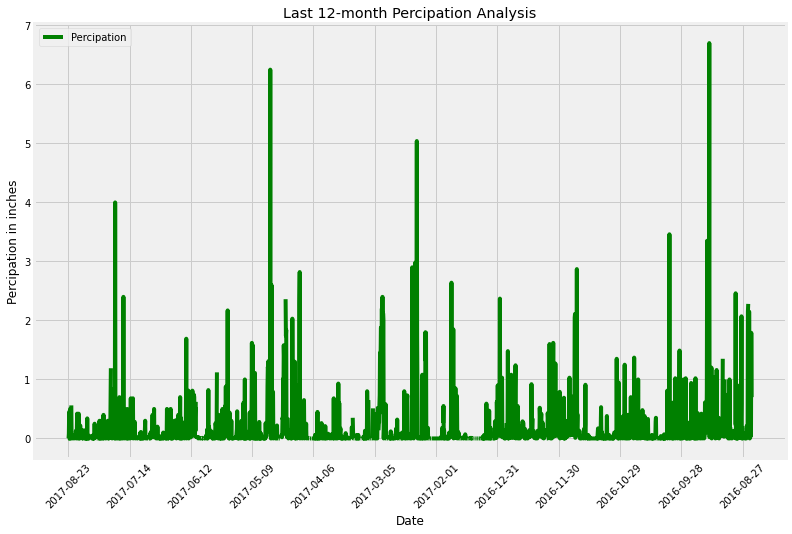

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(0, len(percipation_df), 200)
x_ticks = []
x_dates = (percipation_df.index).to_list()
for i in range(0,len(x_dates),200):
    x_ticks.append(x_dates[i])
percipation_df.plot(figsize=(12,8), color='Green', title='Last 12-month Percipation Analysis',
                    ylabel = 'Percipation in inches')
plt.xticks(x_axis, x_ticks,rotation=45, size=10)

plt.savefig("Images/precipitation_last12months.png")

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percipation_df.describe()


,Percipation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).distinct().count()
total_stations

9

In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.id, Station.id, Measurement.station).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(Measurement.id.desc()).all()
active_stations

[(16939, 9, 'USC00516128'),
 (14960, 8, 'USC00511918'),
 (12188, 7, 'USC00519281'),
 (9519, 6, 'USC00519523'),
 (9008, 5, 'USC00518838'),
 (7636, 4, 'USC00517948'),
 (5434, 3, 'USC00514830'),
 (2725, 2, 'USC00513117'),
 (1, 1, 'USC00519397')]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][1]

temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Station.station == Measurement.station).filter(Measurement.tobs).filter(Station.id == most_active_station)[0]
print("Lowest, Highest & Average temperatiures for station#",most_active_station, " are: ")
print("Lowest Temperature: ", temperatures[0])
print("Highest Temperature: ", temperatures[1])
print("Average Temperature: ", round(temperatures[2],2))


Lowest, Highest & Average temperatiures for station# 9  are: 
Lowest Temperature:  58.0
Highest Temperature:  84.0
Average Temperature:  70.92


In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station plot the results as a histogram

recent_date = session.query(Measurement.date).filter(Station.station == Measurement.station).\
                filter(Station.id == most_active_station).order_by(Measurement.date.desc())[0][0]
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d").date()

recent_year = recent_date - dt.timedelta(days=365)

recent_year_temp = session.query(Measurement.tobs).filter(Measurement.date >= recent_year).\
                                                                order_by(Measurement.date.desc()).all()
recent_year_temp[:10]


[(81.0),
 (82.0),
 (82.0),
 (76.0),
 (82.0),
 (82.0),
 (76.0),
 (81.0),
 (79.0),
 (82.0)]

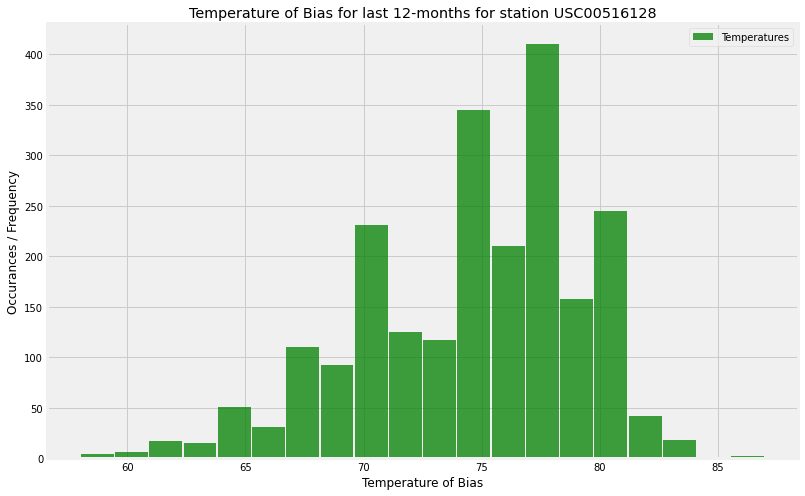

In [22]:
# Reading data into dataframe & plot the results as a histogram
recent_year_temp_df = pd.DataFrame(recent_year_temp, columns = ["Temperatures"])

recent_year_temp_df.plot.hist(grid=True, bins=20, rwidth=0.96,
                   color='Green', figsize=(12,8), alpha=0.75)
plt.title(f'Temperature of Bias for last 12-months for station {active_stations[0][2]}')
plt.xlabel("Temperature of Bias")
plt.ylabel('Occurances / Frequency')

plt.savefig("Images/TOBs_last12months.png")

# Close session

In [23]:
# Close Session
session.close()